In [1]:
from utils import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
trajectories_df = load_filtered_data(years=('2019',), folder='../AIS_data', min_data_points=100)

In [3]:
trajectories_df.head(5)

,MMSI,elapsed_s,LAT,LON,VesselType,Label
0,367659930,"[0, 69, 138, 210, 279, 349, 420, 488, 570, 639...","[30.4289, 30.42774, 30.42675, 30.42573, 30.424...","[-87.99302, -87.99258, -87.9919, -87.99129, -8...",31.0,0
1,367553360,"[0, 70, 149, 220, 301, 379, 449, 559, 630, 709...","[29.01648, 29.01666, 29.01664, 29.01661, 29.01...","[-91.83069, -91.83175, -91.83304, -91.83416, -...",30.0,0
2,367461560,"[0, 64, 134, 204, 274, 354, 425, 495, 45847, 4...","[29.36644, 29.36952, 29.37291, 29.3762, 29.379...","[-91.38801, -91.38525, -91.38225, -91.37948, -...",90.0,0
3,538007067,"[0, 120, 301, 483, 662, 843, 1023, 1204, 1383,...","[28.82299, 28.82325, 28.8236, 28.82388, 28.824...","[-89.33299, -89.33357, -89.3343, -89.33491, -8...",70.0,0
4,369053000,"[0, 70, 139, 209, 270, 340, 410, 473, 540, 610...","[30.18058, 30.17847, 30.17641, 30.17425, 30.17...","[-88.56405, -88.56745, -88.57083, -88.57432, -...",90.0,0


In [4]:
trajectories_df.columns

Index(['MMSI', 'elapsed_s', 'LAT', 'LON', 'VesselType', 'Label'], dtype='object')

In [5]:
counts = trajectories_df['Label'].value_counts()
print(counts)


Label
0    295090
1      1697
Name: count, dtype: int64


In [6]:
def sort_row(row):
    # load into arrays
    e  = np.asarray(row['elapsed_s'])
    la = np.asarray(row['LAT'])
    lo = np.asarray(row['LON'])
    # get the sort‐order
    idx = np.argsort(e)
    # return a Series so apply(...) will build a DataFrame with matching columns
    return pd.Series({
        'elapsed_s': e[idx],
        'LAT'      : la[idx],
        'LON'      : lo[idx]
    })

# apply and overwrite in one go
trajectories_df[['elapsed_s','LAT','LON']] = trajectories_df.apply(sort_row, axis=1)

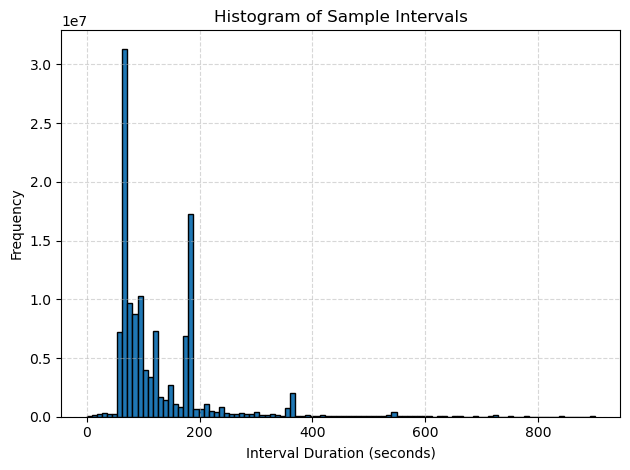

In [7]:
# Step 1: Flatten all sample intervals from all trajectories
all_intervals = []

for elapsed in trajectories_df['elapsed_s']:
    elapsed = np.array(elapsed)
    if len(elapsed) > 1:
        # intervals = np.diff(np.sort(elapsed))  # ensure time is sorted
        intervals = np.diff(elapsed)
        valid_intervals = intervals[(intervals <= 900)]  # filter
        all_intervals.extend(valid_intervals)
        # all_intervals.extend(intervals)
all_intervals = np.array(all_intervals)
import matplotlib.pyplot as plt
plt.figure()
plt.hist(all_intervals, bins=100, edgecolor='black')
plt.title("Histogram of Sample Intervals")
plt.xlabel("Interval Duration (seconds)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [8]:
import numpy as np
import pandas as pd

# threshold in seconds
THRESHOLD = 200

def split_row_into_segments(row, threshold=THRESHOLD):
    """
    Given a row with list‐columns ['elapsed_s','LAT','LON'],
    split into multiple segments whenever elapsed_s gaps > threshold.
    Returns a list of dicts, each dict is one sub-trajectory.
    """
    
    e  = row['elapsed_s']
    la = row['LAT']
    lo = row['LON']
    

    # compute gaps and find break points
    gaps = np.diff(e)
    # break *after* any index i where gap[i] > threshold
    break_idxs = np.where(gaps > threshold)[0]

    # define segment boundaries: starts at 0, each break+1, ends at len(e)
    boundaries = np.concatenate([[0], break_idxs + 1, [len(e)]])

    segments = []

    e = np.asarray(e)
    for start, end in zip(boundaries[:-1], boundaries[1:]):
        seg = {
            'MMSI':        row['MMSI'],
            'VesselType':  row['VesselType'],
            'Label':       row['Label'],
            'elapsed_s':   e[start:end]-e[start],  # normalize to start at 0
            'LAT':         la[start:end],
            'LON':         lo[start:end],
        }
        # only keep segments with at least two points
        if len(seg['elapsed_s']) > 100:
            segments.append(seg)
    return segments

# apply to all rows and flatten
all_segments = []
for _, row in trajectories_df.iterrows():
    all_segments.extend(split_row_into_segments(row))

# build new DataFrame
segmented_df = pd.DataFrame(all_segments)

# reset index if you like
segmented_df = segmented_df.reset_index(drop=True)


In [9]:
trajectories_df['Label'].value_counts()

Label
0    295090
1      1697
Name: count, dtype: int64

In [10]:
segmented_df['Label'].value_counts()

Label
0    153172
1       591
Name: count, dtype: int64

In [11]:
segmented_df

,MMSI,VesselType,Label,elapsed_s,LAT,LON
0,367659930,31.0,0,"[0, 69, 138, 210, 279, 349, 420, 488, 570, 639...","[30.4289, 30.42774, 30.42675, 30.42573, 30.424...","[-87.99302, -87.99258, -87.9919, -87.99129, -8..."
1,367553360,30.0,0,"[0, 61, 140, 220, 290, 381, 470, 551, 661, 731...","[29.00507, 29.00704, 29.00962, 29.01228, 29.01...","[-91.32425, -91.32389, -91.32339, -91.32292, -..."
2,367461560,90.0,0,"[0, 70, 139, 220, 289, 359, 429, 498, 569, 630...","[29.24057, 29.24056, 29.24057, 29.24059, 29.24...","[-91.3781, -91.37811, -91.37811, -91.37813, -9..."
3,369053000,90.0,0,"[0, 70, 139, 209, 270, 340, 410, 473, 540, 610...","[30.18058, 30.17847, 30.17641, 30.17425, 30.17...","[-88.56405, -88.56745, -88.57083, -88.57432, -..."
4,369053000,90.0,0,"[0, 75, 123, 186, 248, 310, 381, 451, 521, 591...","[30.19387, 30.19408, 30.1942, 30.19404, 30.193...","[-88.55647, -88.55652, -88.5568, -88.55742, -8..."
...,...,...,...,...,...,...
153758,215654000,70.0,0,"[0, 66, 198, 294, 365, 438, 504, 582, 659, 749...","[29.34516, 29.34489, 29.34279, 29.34079, 29.33...","[-94.71769, -94.71183, -94.69991, -94.69149, -..."
153759,366816410,90.0,0,"[0, 140, 250, 290, 359, 420, 490, 560, 629, 70...","[29.70259, 29.70258, 29.7026, 29.70258, 29.702...","[-93.54024, -93.54021, -93.54022, -93.54021, -..."
153760,367006560,31.0,0,"[0, 64, 146, 257, 367, 507, 609, 714, 897, 102...","[27.83373, 27.83199, 27.82971, 27.82708, 27.82...","[-97.03891, -97.03575, -97.03173, -97.02609, -..."
153761,538006048,80.0,0,"[0, 81, 180, 270, 311, 381, 461, 531, 600, 671...","[29.29747, 29.29453, 29.29086, 29.28734, 29.28...","[-94.61169, -94.60775, -94.60285, -94.59834, -..."


In [12]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

def resample_fixed_length(row, n_points=156, interval=71):
    elapsed = np.array(row['elapsed_s'])
    lat    = np.array(row['LAT'])
    lon    = np.array(row['LON'])
    label  = row['Label']
    

    t0 = elapsed[0]
    targets = t0 + np.arange(n_points) * interval  # length == 156
    
    # Create interpolators that pad outside the [min, max] range
    lat_i = interp1d(elapsed, lat, kind='linear',
                     bounds_error=False,
                     fill_value=(lat[0], lat[-1]))
    lon_i = interp1d(elapsed, lon, kind='linear',
                     bounds_error=False,
                     fill_value=(lon[0], lon[-1]))
    
    # Evaluate—and you get exactly 156 points
    lat_resamp = lat_i(targets).tolist()
    lon_resamp = lon_i(targets).tolist()
    targets    = targets.tolist()
    
    return pd.Series({
        'elapsed_s': targets,
        'LAT':       lat_resamp,
        'LON':       lon_resamp,
        'Label':     label
    })

# Apply to every trajectory (row) in your DataFrame:
resampled_df = segmented_df.apply(resample_fixed_length, axis=1)
# 

In [13]:
resampled_df

,elapsed_s,LAT,LON,Label
0,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[30.4289, 30.427711304347827, 30.4266933333333...","[-87.99302, -87.99256028985508, -87.9918661111...",0
1,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[29.00507, 29.007366582278483, 29.0096865, 29....","[-91.32425, -91.32382670886076, -91.32337825, ...",0
2,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[29.24057, 29.240560144927535, 29.240570740740...","[-91.3781, -91.37811, -91.37811074074075, -91....",0
3,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[30.18058, 30.17844014492754, 30.1763174285714...","[-88.56405, -88.56749898550724, -88.5709795714...",0
4,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[30.19387, 30.1940688, 30.194151746031746, 30....","[-88.55647, -88.55651733333335, -88.5569869841...",0
...,...,...,...,...
153758,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[29.34516, 29.344810454545453, 29.343680909090...","[-94.71769, -94.7113784848485, -94.70496696969...",0
153759,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[29.70259, 29.70258492857143, 29.7025803636363...","[-93.54024, -93.54022478571429, -93.5402101818...",0
153760,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[27.83373, 27.831795365853658, 27.829821219512...","[-97.03891, -97.03540682926828, -97.0319260975...",0
153761,"[0, 71, 142, 213, 284, 355, 426, 497, 568, 639...","[29.29747, 29.294892962962965, 29.292268686868...","[-94.61169, -94.60823641975308, -94.6047308080...",0


In [43]:
lat_array = np.stack(resampled_df['LAT'].values)    # shape: (num_instances, 156)
lon_array = np.stack(resampled_df['LON'].values)    # shape: (num_instances, 156)

# # Calculate speed (euclidean distance / time)
# dlat = np.diff(lat_array, axis=1)
# dlon = np.diff(lon_array, axis=1)
# # dt = np.diff(elapsed_array, axis=1)
# dt = 71
# # To avoid division by zero
# # dt = np.where(dt == 0, 1e-6, dt)
# speed = np.sqrt(dlat ** 2 + dlon ** 2) / dt  # shape: (num_instances, 155)

# # Pad to match the shape (num_instances, 156)
# speed = np.pad(speed, ((0,0),(1,0)), 'constant', constant_values=0)  # assume 0 speed at start

X = np.stack([lat_array, lon_array], axis=1)  # shape: (num_instances, 2, 156)

y = resampled_df['Label'].values  # shape: (num_instances,)

# MiniRocket

In [ ]:
from sktime.transformations.panel.rocket import MiniRocket

# For example, 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=500, stratify=y  # stratify if classification
)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

rocket = MiniRocket(num_kernels=1000, random_state=100, n_jobs=-1)  
X_train_tf = rocket.fit_transform(X_train)
X_test_tf = rocket.transform(X_test)


from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train_tf, y_train)
y_pred = clf.predict(X_test_tf)
print(classification_report(y_test, y_pred))


(123010, 2, 156) (30753, 2, 156)
(123010,) (30753,)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30635
           1       0.88      0.38      0.53       118

    accuracy                           1.00     30753
   macro avg       0.94      0.69      0.77     30753
weighted avg       1.00      1.00      1.00     30753



In [42]:
y_pred = clf.predict(X_train_tf)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    122537
           1       1.00      1.00      1.00       473

    accuracy                           1.00    123010
   macro avg       1.00      1.00      1.00    123010
weighted avg       1.00      1.00      1.00    123010



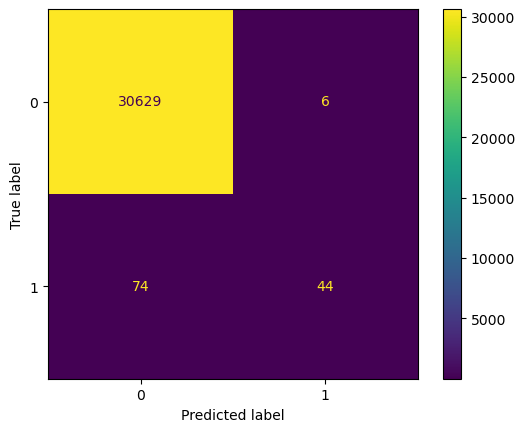

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [25]:
# from sktime.classification.kernel_based import RocketClassifier

# clf = RocketClassifier(num_kernels=500, random_state=42, n_jobs=-1)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

# print(classification_report(y_test, y_pred))

In [ ]:
# from sktime.classification.deep_learning.cnn import CNNClassifier
# cnn = CNNClassifier(n_epochs=20,batch_size=1024,loss='binary_crossentropy')  
# cnn.fit(X_train, y_train)

ModuleNotFoundError: tensorflow is required for deep learning functionality in `sktime`. To install these dependencies, run: `pip install sktime[dl]`

In [20]:
sum(y_test)

np.int64(118)

In [17]:
from sktime.transformations.panel.rocket import MiniRocket
from sklearn.linear_model import RidgeClassifierCV

rocket = MiniRocket(num_kernels=1000, random_state=42)  
X_train_tf = rocket.fit_transform(X_train)
X_test_tf = rocket.transform(X_test)

# clf = RidgeClassifierCV(class_weight='balanced')
# clf.fit(X_train_tf, y_train)
# y_pred = clf.predict(X_test_tf)
# print(classification_report(y_test, y_pred))

In [18]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train_tf, y_train)
y_pred = clf.predict(X_test_tf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30635
           1       0.96      0.41      0.57       118

    accuracy                           1.00     30753
   macro avg       0.98      0.70      0.79     30753
weighted avg       1.00      1.00      1.00     30753



In [ ]:
# X_train = X_train.to_numpy()

In [ ]:
print(type(X_train.iloc[0]))

In [47]:
segmented_df

,MMSI,VesselType,Label,elapsed_s,LAT,LON
0,367659930,31.0,0,"[0, 69, 138, 210, 279, 349, 420, 488, 570, 639...","[30.4289, 30.42774, 30.42675, 30.42573, 30.424...","[-87.99302, -87.99258, -87.9919, -87.99129, -8..."
1,367553360,30.0,0,"[0, 61, 140, 220, 290, 381, 470, 551, 661, 731...","[29.00507, 29.00704, 29.00962, 29.01228, 29.01...","[-91.32425, -91.32389, -91.32339, -91.32292, -..."
2,367461560,90.0,0,"[0, 70, 139, 220, 289, 359, 429, 498, 569, 630...","[29.24057, 29.24056, 29.24057, 29.24059, 29.24...","[-91.3781, -91.37811, -91.37811, -91.37813, -9..."
3,369053000,90.0,0,"[0, 70, 139, 209, 270, 340, 410, 473, 540, 610...","[30.18058, 30.17847, 30.17641, 30.17425, 30.17...","[-88.56405, -88.56745, -88.57083, -88.57432, -..."
4,369053000,90.0,0,"[0, 75, 123, 186, 248, 310, 381, 451, 521, 591...","[30.19387, 30.19408, 30.1942, 30.19404, 30.193...","[-88.55647, -88.55652, -88.5568, -88.55742, -8..."
...,...,...,...,...,...,...
153758,215654000,70.0,0,"[0, 66, 198, 294, 365, 438, 504, 582, 659, 749...","[29.34516, 29.34489, 29.34279, 29.34079, 29.33...","[-94.71769, -94.71183, -94.69991, -94.69149, -..."
153759,366816410,90.0,0,"[0, 140, 250, 290, 359, 420, 490, 560, 629, 70...","[29.70259, 29.70258, 29.7026, 29.70258, 29.702...","[-93.54024, -93.54021, -93.54022, -93.54021, -..."
153760,367006560,31.0,0,"[0, 64, 146, 257, 367, 507, 609, 714, 897, 102...","[27.83373, 27.83199, 27.82971, 27.82708, 27.82...","[-97.03891, -97.03575, -97.03173, -97.02609, -..."
153761,538006048,80.0,0,"[0, 81, 180, 270, 311, 381, 461, 531, 600, 671...","[29.29747, 29.29453, 29.29086, 29.28734, 29.28...","[-94.61169, -94.60775, -94.60285, -94.59834, -..."


In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score




# Apply feature extraction

print(type(segmented_df))
features = segmented_df.apply(extract_features, axis=1)
# features = extract_tsfresh_features(all_df)


<class 'pandas.core.frame.DataFrame'>


In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_curve,
    f1_score,
    classification_report
)

# 1) Prepare features and labels
selected_features = [
    'duration',
    'lat_mean', 'lon_mean',
    'lat_std',  'lon_std',
    'lat_median','lon_median',
    'lat_max',  'lon_max',
    'lat_min',  'lon_min',
    'start_lat','start_lon',
    'end_lat',  'end_lon',
    'lat_range','lon_range',
    'speed_mean','speed_max','speed_std',
    # 'wspd','gst','wvht','atmp'
]
X = features[selected_features]
# y = all_df['Label']
y = segmented_df['Label']

# 2) Split into train+val (80 %) and test (20 %)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.20,
    random_state=42
)

# 3) Split train+val into train (60 %) and val (20 %)
#    Since X_temp is 80 %, using test_size=0.25 on it gives 0.25*0.8 = 0.20 overall
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    stratify=y_temp,
    test_size=0.25,
    random_state=42
)

# 4) Define your classifiers
clfs = {
    'RandomForest': RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_estimators=100
    ),
}

# 5) Train, tune threshold on validation, and report
best_thresholds = {}
for name, clf in clfs.items():
    # Train
    clf.fit(X_train, y_train)
    
    # Get validation scores
    val_scores = clf.predict_proba(X_val)[:, 1]
    
    # Compute precision–recall curve
    precision, recall, thresholds = precision_recall_curve(y_val, val_scores)
    
    # Compute F1 for each threshold (exclude last point)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-6)
    
    # Pick best
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1_val = f1_scores[best_idx]
    best_thresholds[name] = best_threshold
    
    print(f"{name} → best validation threshold = {best_threshold:.4f} (F1 = {best_f1_val:.4f})")

# 6) Evaluate on the test set using the tuned thresholds
for name, clf in clfs.items():
    thresh = best_thresholds[name]
    thresh = 0.5
    test_scores = clf.predict_proba(X_test)[:, 1]
    y_test_pred = (test_scores >= thresh).astype(int)
    
    print(f"\n{name} test set @ threshold {thresh:.4f}:")
    print(classification_report(y_test, y_test_pred))


RandomForest → best validation threshold = 0.3200 (F1 = 0.6000)

RandomForest test set @ threshold 0.5000:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30635
           1       0.94      0.43      0.59       118

    accuracy                           1.00     30753
   macro avg       0.97      0.72      0.80     30753
weighted avg       1.00      1.00      1.00     30753



In [ ]:
importances = clf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
n = 20
top_n_features = importance_df['Feature'].head(n).tolist()
print(f"\nTop {n} Important Features (RandomForest):")
print(importance_df.head(n))